**source: [perceptron.py](https://github.com/Nicholas-Sliter/middlebury-csci-0451/tree/main/posts/perceptron/perceptron.py)**

Welcome to the first in a series of blog posts exploring the fundamentals of machine learning. This blog is a component of CSCI 0451: Machine Learning at Middlebury College. My name is Nicholas Sliter, and I am a senior at Middlebury College studying Computer Science and Mathematics.

 In this post, we will be exploring the perceptron algorithm, a simple machine learning algorithm that is the basis for many more complex algorithms. We will be implementing the perceptron algorithm in Python and using it classify binary-labeled synthetic data.

To begin, we will generate a linearly separable dataset of binary-labeled 2D points.

 We will use the `make_blobs` function from `sklearn.datasets` to generate the data. The `make_blobs` function takes in a number of samples, a number of features, and a number of classes. It then generates a dataset of points with the specified number of samples and features, and labels the points with the specified number of classes.

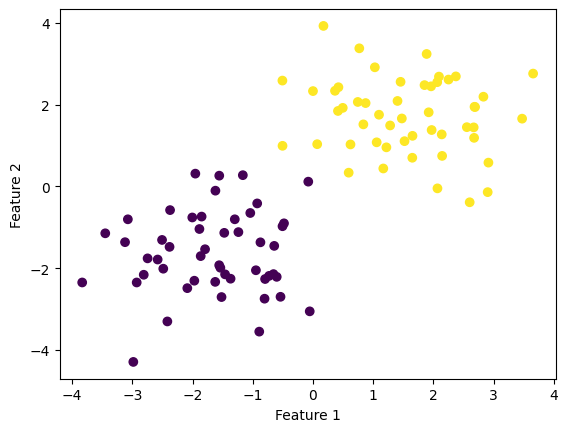

In [59]:
import numpy as np
import seaborn as sns
import polars as pl
from matplotlib import pyplot as plt

from sklearn.datasets import make_blobs


np.random.seed(1234532)

n = 100
p_features = 3

X, y = make_blobs(n_samples = 100, n_features = p_features - 1, centers = [(-1.7, -1.7), (1.7, 1.7)]) # type: ignore


fig = plt.scatter(X[:,0], X[:,1], c = y) # type: ignore
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")


We can see two distinct clusters of points. We also observe that the points are linearly separable, meaning that we can draw a line that separates the two clusters of points.

## Perceptron Model

Now we will find that separating line using a custom-made perceptron model. The model takes in our feature matrix `X` and our label vector `y`. It then performs the following steps:

1. Initialize the weights and bias to random values.
2. Iterate through the data, updating the weights and bias until...
    a.  the model is able to correctly classify all of the points, or
    b.  the maximum number of iterations is reached, or
    c.  the model reaches an optionally-defined loss threshold.

The `fit` method performs the steps above. The `predict` method takes in a feature matrix `X` and returns the predicted labels for each point in `X`.

And `perceptron.history` gives a list of accuracy scores for each iteration of the model.

Fit model in 114 steps with score 1.0


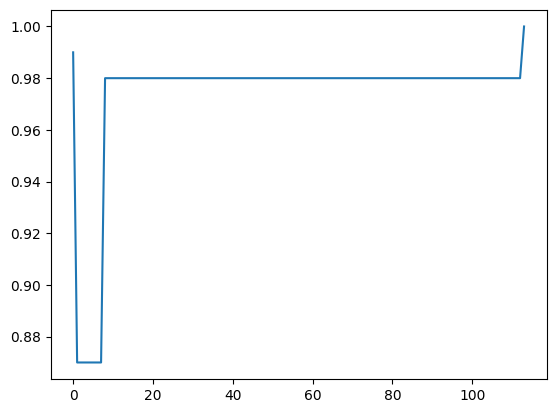

In [2]:
from perceptron import Perceptron

perceptron = Perceptron()

perceptron.fit(X, y) # type: ignore

fig = plt.plot(perceptron.history)

Observe the accuracy of the model need not follow a monotonic trend.

In [3]:
perceptron.w


array([ 0.68974191,  2.39236714, -0.80889108])

Here we can see the separating line that the model found with the added bias term.

In [4]:
print(X[1])

[2.06270619 2.55152881]


In [5]:
# Test prediction on a fake point

point = np.array([[1, 2]]) # should have label 1
prediction = perceptron.predict(point)
print(f"Prediction for point {point} is {prediction[0]}")


Prediction for point [[1 2]] is 1


In [6]:
def draw_line(w, x_min, x_max):
  x = np.linspace(x_min, x_max, 101)
  y = -(w[0]*x + w[2])/w[1]
  plt.plot(x, y, color = "#333", linestyle = "dashed")

In [51]:
def plot_history(history, step_size = 1):

    ax = (sns.lineplot(
            x = range(0, len(history)*step_size, step_size), 
            y = history, 
            errorbar=None,
         ))

    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Step")
    ax.set_title("Perceptron Accuracy History")
    ax.set_facecolor("#fafafa")

    return ax
    

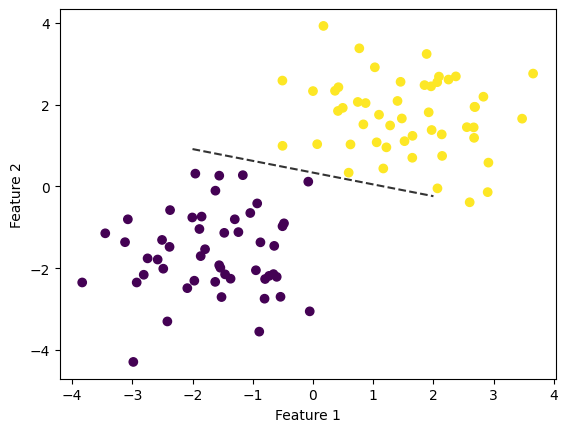

In [8]:
fig = plt.scatter(X[:,0], X[:,1], c = y) # type: ignore
fig = draw_line(perceptron.w, -2, 2)

xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")

Observe that this line is precisely the separating line specified by `perceptron.w`.

In [60]:
def plot_simple_scatter(X, y, xlab = "", ylab = "", title = None,):
    df = pl.DataFrame({"x": X[:,0], "y": X[:,1], "label": y})
    ax = (sns.scatterplot(
        data = df,
        x = "x",
        y = "y",
        hue = "label",
        palette = ["g", "b"],
    ))

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    # ax.set_facecolor("#fafafa")
    ax.set_facecolor("#f1f3f5")

    if title is not None:
        ax.set_title(title)

    return ax # allows for further customization




We know that the perceptron model is guaranteed to converge to a separating line if the data is linearly separable. But what happens if we feed the model data that is not linearly separable?

## Non-Linearly Separable Data:

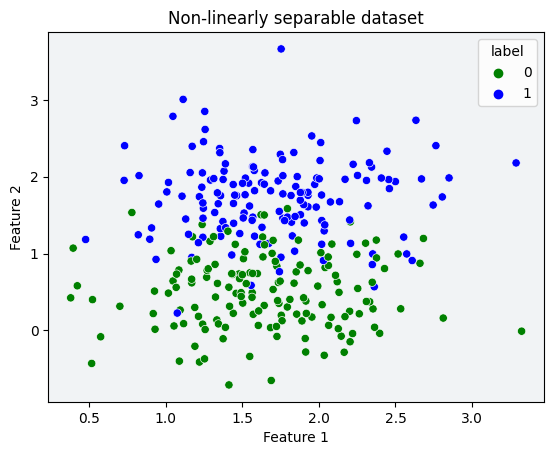

In [10]:
# Let's try to fit to a non-linearly separable dataset

seed = 12345 # we are reseeding so we can run each cell independently
np.random.seed(seed)

nX, ny = make_blobs(n_samples = 300, n_features = p_features - 1, centers = [(1.7, 0.5), (1.7, 1.7)], cluster_std = 0.5) # type: ignore

ax = plot_simple_scatter(nX, ny, xlab = "Feature 1", ylab = "Feature 2", title = "Non-linearly separable dataset")


Clearly, this data is not linearly separable. Let's see what happens when we feed it to the perceptron model.

In [61]:
# Let's try to fit to a non-linearly separable dataset
p = Perceptron()
p.fit(nX, ny, 10000) # type: ignore


Fit model in 10000 steps with score 0.8866666666666667


So we converged after `max_steps` iterations. But we did not converge to a line that perfectly separates the data. Indeed, under these conditions, if we did not feed the model a maximum number of iterations, it would never converge and would instead run forever.

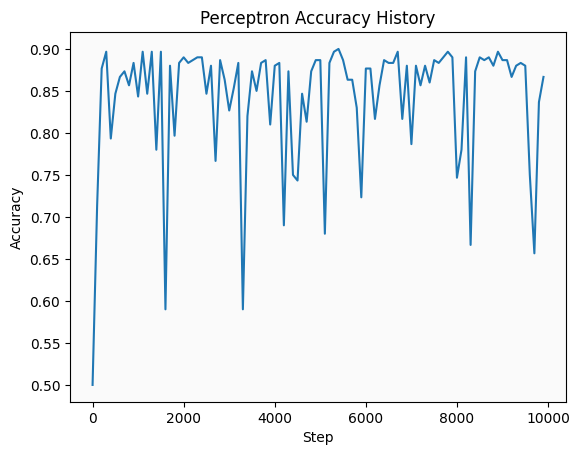

In [62]:
# plot_history(p.history) produces too much noise
history_subset = [p.history[i] for i in range(0, len(p.history), 100)]

ax = plot_history(history_subset, 100)

As you can see the accuracy of the model 'ping-pongs' around and is never able to reach far above `0.9`. But what if we had a way to short circuit the model when it's accuracy is 'good enough'?


```python
while (not self.__has_epsilon_converged(X_, y, epsilon)) and i < max_steps:
            self.__update_weights(X_, y, self.w, rate)
            self.__record_history(X_, y)
            i += 1
```


Looking into our loop code, this is exactly what `__has_epsilon_converged(X_, y, epsilon)` does. Given some $\epsilon$-threshold, it checks if the model's loss is $\leq$ that threshold. If it is, it returns `True` and the model stops training. If it is not, it returns `False` and the model continues training.

But this example was trained with $\epsilon = 0$, meaning it only stops when it reaches 100% accuracy.

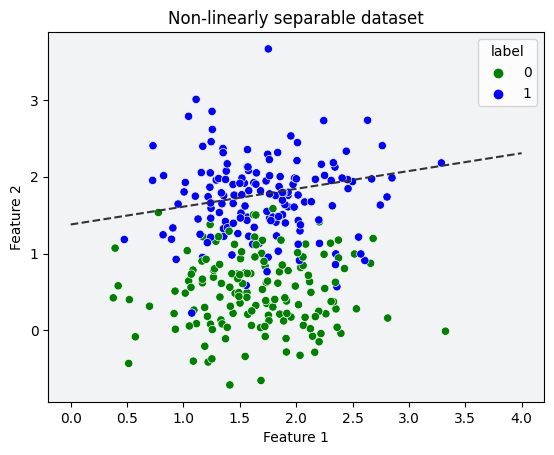

In [12]:
# Check accuracy and plot decision boundary
p.score(nX, ny) # type: ignore

ax = plot_simple_scatter(nX, ny, xlab = "Feature 1", ylab = "Feature 2", title = "Non-linearly separable dataset")
ax = draw_line(p.w, 0, 4)

Let's see if we can improve our model by using this new feature.

Fit model in 9 steps with score 0.8866666666666667


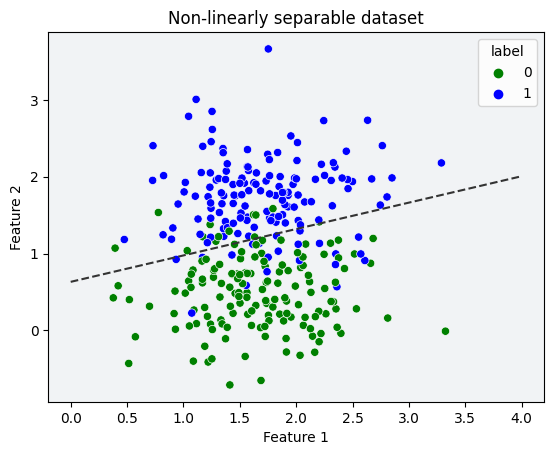

In [13]:
# Now let's try with epsilon = 0.15

seed = 12345
np.random.seed(seed)

p = Perceptron()
lr = 1
e = 0.15
p.fit(nX, ny, 10000, lr, e) # type: ignore

ax = plot_simple_scatter(nX, ny, xlab = "Feature 1", ylab = "Feature 2", title = "Non-linearly separable dataset")
ax = draw_line(p.w, 0, 4)

Model short-circuiting works.  In 9 steps, we have higher accuracy than the 10k step previous example. With some hyperparameter tuning on $\epsilon$, we could probably get even better results.

## Higher Dimensional Data:


We can also use the perceptron model to classify data with more than two features. Let's see what happens when we feed the model data with five features.

While we lose the ability to (easily) visualize the data, we will still see that the model is able to find a separating line.

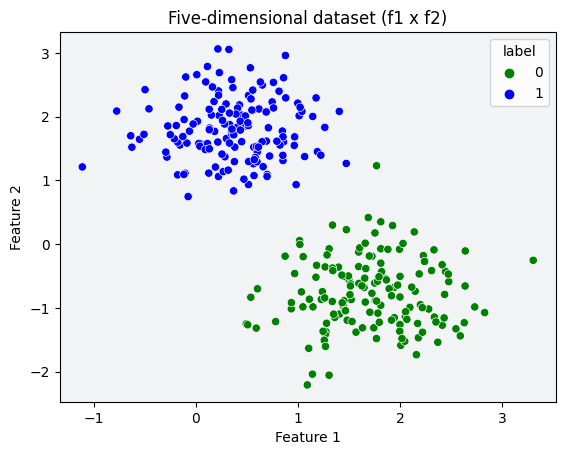

In [56]:
# Try higher dimensionality (5 features)

seed = 12345
np.random.seed(seed)

center1 = np.random.uniform(-2, 2, 5)
center2 = np.random.uniform(-2, 2, 5)

hX, hy = make_blobs(n_samples = 300, n_features = 5, centers = [center1, center2], cluster_std = 0.5) # type: ignore

# Test f1 x f2
ax = plot_simple_scatter(hX[:,[0,1]], hy, xlab = "Feature 1", ylab = "Feature 2", title = "Five-dimensional dataset (f1 x f2)")


The above (f1 x f2) plot is a 2D projection of the 5D data. This plot is not very useful, but it provides a limited visual representation of the data and interestingly, implies that the data is linearly separable.

In [57]:
seed = 123456 # seed of 12345 converges in 1 step
np.random.seed(seed)

p = Perceptron()
p.fit(hX, hy, 10000, 1) # type: ignore


Fit model in 33 steps with score 1.0


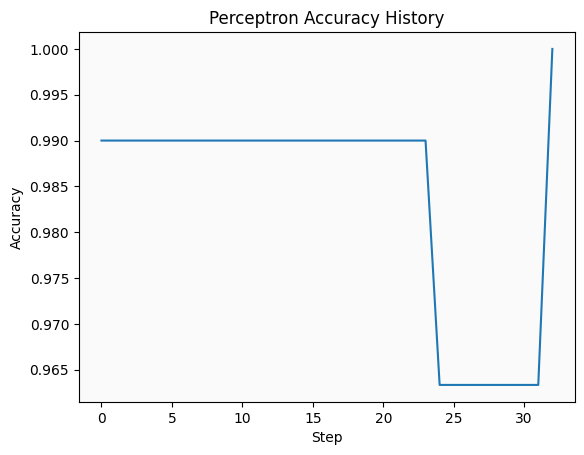

In [58]:
ax = plot_history(p.history)

Clearly, our 5D data is linearly separable since we achieve 100% accuracy.

## Update-step time complexity:

$$\tilde{\mathbf{w}}^{(t+1)} = \tilde{\mathbf{w}}^{(t)} + \mathbb{1}(\tilde{y}_i \langle \tilde{\mathbf{w}}^{(t)}, \tilde{\mathbf{x}}_i\rangle < 0)\tilde{y}_i \tilde{\mathbf{x}}_i\;$$


The update step features a dot product between the weights and the input vector. A dot product is O(p) where p is the number of features. The other operations are simple additions and multiplications, which are ~O(1). The dominate operations are O(p), therefore, the update step has an overall time complexity of O(p).


##### Consider the following weight update function:

```python

    def __update_weights(self, X, y, w, rate) -> None:
        ''' Internal method to update model weights
        @param X: 2D array of shape (n_samples, n_features + 1)
        @param y: 1D array of shape (n_samples) of labels (0 or 1)
        @param w: 1D array of shape (n_features + 1) of weights
        @param rate: float of the learning rate
        @return: None
        '''
        index = np.random.randint(0, len(X))
        y_hat = 2 * y[index] - 1

        self.w = w + int(y_hat * np.dot(X[index], w) < 0) * rate * (X[index] * y_hat)

```
This is the in-code implementation of the update step. We begin by randomly selecting a point from the dataset. We get the label of this point and convert it to a $-1$ or $1$. We then compute the dot product between the weights and the input vector. If the dot product is less than $0$, we update the weights. 

The updated weight vector is computed by multiplying the learning rate ($1$) by the input vector and our modified label $\in \{-1,1\}$. We then add this to the existing weights.

The only computationally expensive operation is the dot product. All others, including the random index selection, array indexing, type coercion, addition, and multiplication are ~O(1).

## Sources:
* [1] [Perceptron title-card image](https://datascientest.com/en/perceptron-definition-and-use-cases)